In [1]:
import sys

In [2]:
sys.version

'3.6.1 |Continuum Analytics, Inc.| (default, May 11 2017, 13:09:58) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

In [3]:
%pylab --no-import-all inline

Populating the interactive namespace from numpy and matplotlib


In [12]:
from pathlib import Path
from imageio import imread
from skimage import transform

In [378]:
ds_masks_path = Path('GS/ion_image_templates/masks')

In [30]:
gs_path = Path('GS/raw_images/')

In [85]:
gs_ds_paths = list(gs_path.iterdir())

In [368]:
# masks exist for: [Kidney_280x140_40um_E0, Tumor11]

In [293]:
for ds_path in gs_ds_paths[:20]:
    img_path = next((ds_path / 'on').iterdir())
    img_shape = imread(img_path).shape[:2]
    print(f"{img_shape} - {ds_path.name.replace('__', '//')}")

(70, 88) - Tumor11
(94, 95) - ICL//LNTO30_16_1
(34, 41) - Tumor41
(116, 111) - 161007_WT1S1L1
(74, 74) - UoNotreDame//Untreated_6_574
(140, 280) - Kidney_280x140_40um_E0
(98, 119) - Dataset 16
(101, 51) - Row001
(92, 151) - Esco1_centroids
(119, 164) - Xenograft_3_135um
(197, 220) - DESI porcine kidney interface region
(137, 228) - HK_S2_N2_20um_New
(320, 100) - MPIMM_049_QE_P_BA_CF_sp3
(119, 94) - Dataset 4_recal
(60, 68) - 12_cylces_75um_new_submission
(88, 108) - ICL//LNTO41_17_2
(105, 155) - S649 WS21 155x105 15um E110
(126, 137) - Dataset 23
(126, 90) - Dataset 3
(84, 151) - ST-Pseudo_centroids


# Load Mask and Ion Images

In [558]:
def read_image(path, mask=False):
    img = imread(path)[:,:,0]
    img = img / 255.
    return np.around(img).astype(int) if mask else img

In [573]:
mask_path = list(ds_masks_path.iterdir())[0]
mask = read_image(mask_path, mask=True)
mask_path

PosixPath('GS/ion_image_templates/masks/Dataset 3.png')

In [574]:
ds_name = mask_path.name.split('.')[0]
ds_name

'Dataset 3'

In [680]:
img_path = list((gs_path / ds_name / 'off').iterdir())[5]
img = read_image(img_path)
img_path

PosixPath('GS/raw_images/161007_WT1S1L1/off/C26H40O6+H.png')

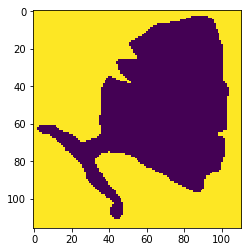

In [681]:
plt.imshow(mask)

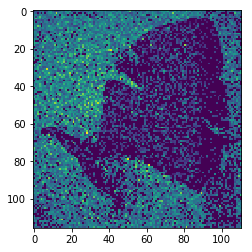

In [682]:
plt.imshow(img);

# Image Match Metrics

In [611]:
mask_flat, img_flat = mask.flatten(), img.flatten()

img_bin = img.copy()
img_bin[img_bin > 0] = 1
img_bin_flat = img_bin.flatten()

img_bin_01 = img.copy()
img_bin_01[img_bin_01 > 0.1] = 1
img_bin_01_flat = img_bin_01.flatten()

img_bin_05 = img.copy()
img_bin_05[img_bin_05 > 0.5] = 1
img_bin_05_flat = img_bin_05.flatten()

In [612]:
def correlation(x, y):
    return np.corrcoef(x, y)[0,1]

(correlation(mask_flat, img_flat), correlation(mask_flat, img_bin_flat),
 correlation(mask_flat, img_bin_01_flat), correlation(mask_flat, img_bin_05_flat))

(-0.63444748695447806,
 -0.69898215905927685,
 -0.49766266444357043,
 -0.61467651900215814)

In [613]:
def mask_area(mask):
    return mask.sum() / mask.size

mask_a = mask_area(mask)
mask_a

0.48544973544973546

In [614]:
def cosine_sim(x, y):
    return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))

(cosine_sim(mask_flat, img_flat), cosine_sim(mask_flat, img_bin_flat),
 cosine_sim(mask_flat, img_bin_01_flat), cosine_sim(mask_flat, img_bin_05_flat))

(0.076314700335772714,
 0.11889046389053121,
 0.032895285503055441,
 0.074492769662719435)

In [615]:
def l2_normalize(v):
    norm = np.sqrt(np.sum(np.square(v)))
    return v / norm

def euclidean_sim(x, y):   
    return 1 / np.sqrt(np.sum((l2_normalize(x) - l2_normalize(y)) ** 2))

euclidean_sim(mask_flat, img_flat), euclidean_sim(mask_flat, img_bin_flat)

(0.73573765911445943, 0.75330361469978369)

In [616]:
def dice(x, y):
    return 2 * np.dot(x, y) / (np.dot(x, x) + np.dot(y, y))

(dice(mask_flat, img_flat), dice(mask_flat, img_bin_flat),
 dice(mask_flat, img_bin_01_flat), dice(mask_flat, img_bin_05_flat))

(0.016788821580243037,
 0.11888624290163033,
 0.030070021291230539,
 0.016778645041364917)

In [617]:
def jaccard(x, y):
    return np.dot(x, y) / (np.dot(x, x) + np.dot(y, y) - np.dot(x, y))

jaccard(mask_flat, img_flat), jaccard(mask_flat, img_bin_flat)

(0.0084654734518088692, 0.063199922095627623)

In [618]:
def img_on_off_area(mask, img, off=True, thr=None):
    cl = 1 if off else 0
    img_off_size = img[mask == cl].size
    if thr is not None:
        cl_size = (img[mask == cl] > thr).sum()
    else:
        cl_size = img[mask == cl].sum()
    return cl_size / img_off_size

def img_on_off_area_diff(mask, img, thr=None):
    off_area = img_on_off_area(mask, img, off=True, thr=thr)
    on_area = img_on_off_area(mask, img, off=False, thr=thr)
    return off_area - on_area
    
img_on_off_area(mask, img, off=True, thr=0.1), img_on_off_area(mask, img, off=False, thr=0.1), img_on_off_area_diff(mask, img, thr=0.1)

(0.014713896457765668, 0.38234790059982859, -0.36763400414206293)

In [360]:
img_on_off_area(mask, img, off=True, thr=0), img_on_off_area(mask, img, off=False, thr=0)

(0.51097522734399503, 0.6990999848736954)

In [362]:
img_on_off_area(mask, img, off=True, thr=0.1), img_on_off_area(mask, img, off=False, thr=0.1)

(0.016306052053935403, 0.24315534714869158)

# Compute Image Match Features

In [655]:
import pandas as pd
from collections import OrderedDict

In [656]:
def compute_features(mask, img):
    mask_flat, img_flat = mask.flatten(), img.flatten()

    img_bin_flat = img_flat.copy()
    img_bin_flat[img_bin_flat > 0] = 1

    img_bin_01 = img.copy()
    img_bin_01[img_bin_01 > 0.1] = 1
    img_bin_01_flat = img_bin_01.flatten()
    
    return {
        'off_on_area_diff': img_on_off_area_diff(mask, img, thr=0.1),
        'corr': correlation(mask_flat, img_flat),
        'corr_bin': correlation(mask_flat, img_bin_flat),
        'corr_01_bin': correlation(mask_flat, img_bin_01_flat),
        'mask_area': mask_area(mask),
        'cosine_sim': cosine_sim(mask_flat, img_flat),
        'cosine_sim_bin': cosine_sim(mask_flat, img_bin_flat),
        'cosine_sim_01_bin': cosine_sim(mask_flat, img_bin_01_flat),
#         'euclidean_sim': euclidean_sim(mask_flat, img_flat),
#         'euclidean_sim_bin': euclidean_sim(mask_flat, img_bin_flat),
#         'euclidean_sim_01_bin': euclidean_sim(mask_flat, img_bin_01_flat),
        'dice': dice(mask_flat, img_flat),
        'dice_bin': dice(mask_flat, img_bin_flat),
        'dice_01_bin': dice(mask_flat, img_bin_01_flat),
        'jaccard': jaccard(mask_flat, img_flat),
        'jaccard_bin': jaccard(mask_flat, img_bin_flat),
        'jaccard_01_bin': jaccard(mask_flat, img_bin_01_flat)
#         'off_area_true': img_on_off_area(mask, img, off=True),
#         'on_area_true': img_on_off_area(mask, img, off=False),
#         'off_area_true_bin': img_on_off_area(mask, img, off=True, thr=0),
#         'on_area_true_bin': img_on_off_area(mask, img, off=False, thr=0),
#         'off_area_true_01_bin': img_on_off_area(mask, img, off=True, thr=0.1),
#         'on_area_true_01_bin': img_on_off_area(mask, img, off=False, thr=0.1),
    }

In [657]:
ion_images, features_list, labels = [], [], []

for mask_path in list(ds_masks_path.iterdir()):
    mask = read_image(mask_path, mask=True)
    ds_name = mask_path.name.split('.')[0]
    print(ds_name)

    for label in ['off', 'on']:
        for img_path in list((gs_path / ds_name / label).iterdir()):
            img = read_image(img_path)
            ion_images.append(img)
            labels.append(l)
            
            features = compute_features(mask, img)
            features['label'] = label == 'off'
            features['group'] = ds_name
            features_list.append(features)
            print('.', end='')

Dataset 3
........................................................................................................................................................................................................................................................................................................................................................Kidney_280x140_40um_E0
..........................................................................................................................................................................DESI porcine kidney interface region
................................................................................................................................................................................................................................................................................................................................................................................................................................

In [664]:
df = pd.DataFrame(features_list)
df.shape

(2731, 16)

In [665]:
df.head()

,corr,corr_01_bin,corr_bin,cosine_sim,cosine_sim_01_bin,cosine_sim_bin,dice,dice_01_bin,dice_bin,group,jaccard,jaccard_01_bin,jaccard_bin,label,mask_area,off_on_area_diff
0,0.238593,0.231992,0.231661,0.381781,0.388228,0.388074,0.133512,0.301451,0.301406,Dataset 3,0.071531,0.177475,0.177445,True,0.48545,0.145334
1,0.646367,0.275401,0.203290,0.836911,0.721155,0.707505,0.696523,0.692126,0.674754,Dataset 3,0.534358,0.529200,0.509154,True,0.48545,0.190151
2,0.291653,0.135411,-0.025922,0.599818,0.545844,0.506372,0.323608,0.545459,0.505258,Dataset 3,0.193038,0.375004,0.338023,True,0.48545,0.145169
3,0.423671,0.440351,0.346330,0.625398,0.657112,0.631327,0.254562,0.641718,0.628028,Dataset 3,0.145845,0.472448,0.457756,True,0.48545,0.410273
4,0.619302,0.187256,0.090856,0.825357,0.705285,0.693051,0.690558,0.672260,0.656079,Dataset 3,0.527368,0.506319,0.488182,True,0.48545,0.111207


In [666]:
df.insert(0, 'off_on_diff', df.off_on_area_diff)

In [667]:
df.head()

,off_on_diff,corr,corr_01_bin,corr_bin,cosine_sim,cosine_sim_01_bin,cosine_sim_bin,dice,dice_01_bin,dice_bin,group,jaccard,jaccard_01_bin,jaccard_bin,label,mask_area,off_on_area_diff
0,0.145334,0.238593,0.231992,0.231661,0.381781,0.388228,0.388074,0.133512,0.301451,0.301406,Dataset 3,0.071531,0.177475,0.177445,True,0.48545,0.145334
1,0.190151,0.646367,0.275401,0.203290,0.836911,0.721155,0.707505,0.696523,0.692126,0.674754,Dataset 3,0.534358,0.529200,0.509154,True,0.48545,0.190151
2,0.145169,0.291653,0.135411,-0.025922,0.599818,0.545844,0.506372,0.323608,0.545459,0.505258,Dataset 3,0.193038,0.375004,0.338023,True,0.48545,0.145169
3,0.410273,0.423671,0.440351,0.346330,0.625398,0.657112,0.631327,0.254562,0.641718,0.628028,Dataset 3,0.145845,0.472448,0.457756,True,0.48545,0.410273
4,0.111207,0.619302,0.187256,0.090856,0.825357,0.705285,0.693051,0.690558,0.672260,0.656079,Dataset 3,0.527368,0.506319,0.488182,True,0.48545,0.111207


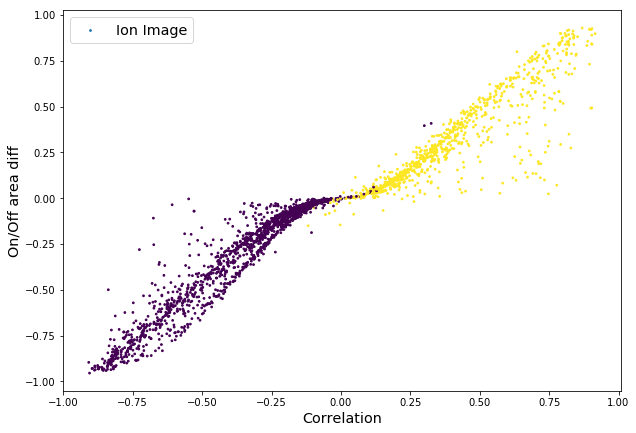

In [734]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.scatter(df['corr'], df.off_on_area_diff, c=df.label, s=3)
ax.set_xlabel('Correlation', fontsize='x-large')
ax.set_ylabel('On/Off area diff', fontsize='x-large')
ax.legend(['Ion Image'], fontsize='x-large');

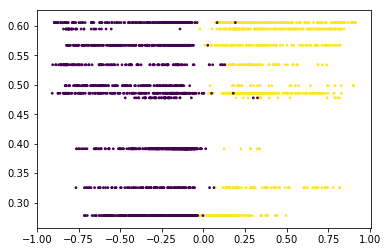

In [648]:
plt.scatter(df['corr'], df.mask_area, c=df.label, s=3)

# Train Classifier

In [668]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_validate

In [669]:
X = df.drop(['label', 'group'], axis=1).values #[:,:3]
y = df.label.values
groups = df.group.values
X.shape, y.shape, groups.shape

((2731, 15), (2731,), (2731,))

In [670]:
u_groups_n = np.unique(groups).shape[0]
u_groups_n

10

In [671]:
clf = LogisticRegression()
# clf = RandomForestClassifier(n_estimators=20, max_depth=3, min_samples_split=10)
# clf = GradientBoostingClassifier(n_estimators=50, min_samples_split=10, learning_rate=0.05)

cv_results = cross_validate(clf, X, y, groups, cv=u_groups_n,
                            return_train_score=True, scoring='accuracy')
print('Train:', cv_results['train_score'].mean(), cv_results['train_score'].std())
print('Test:', cv_results['test_score'].mean(), cv_results['test_score'].std())

Train: 0.987265637766 0.00120659275603
Test: 0.986107234865 0.0141167401566


In [672]:
# clf = RandomForestClassifier(n_estimators=20, max_depth=3, min_samples_split=10)
clf = GradientBoostingClassifier(n_estimators=50, min_samples_split=10, learning_rate=0.05)
clf.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

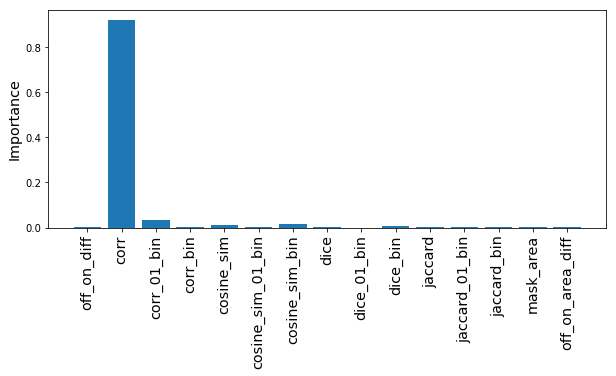

In [732]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
left_bar_pos = np.arange(len(clf.feature_importances_))
ax.bar(left_bar_pos, clf.feature_importances_)
xtick_labels = df.drop(['label', 'group'], axis=1).columns.values
ax.set_xticks(np.arange(len(xtick_labels)))
ax.set_xticklabels(xtick_labels, rotation='vertical', fontsize='x-large');
ax.set_ylabel('Importance', fontsize='x-large');

### Difficult Cases

In [739]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [740]:
X_train.shape, X_test.shape

((2457, 15), (274, 15))

In [741]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)